In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numba import njit
import pandas as pd

In [2]:
@njit(fastmath=True)
def scan_qty(lon_c_arr, lat_c_arr, qty_arr, count_arr, 
             lon, lat, qty, cone_size, lon_step, lat_step, cos_weight=True,
             ):
    """
    Scan and average to make quantity sky map. Mainly use for bulk flow calculation, 
    namely to calculate the line of sight velocity maps. This is the numba accelerated
    main calculation of the code.
    """

    # unit conversions
    theta = cone_size # set alias
    theta_rad = theta * np.pi / 180
    lat_rad = lat * np.pi / 180 # the memory load is not very high so we can do this
    lon_rad = lon * np.pi / 180

    n_tot = len(lon)

    for lon_c in range(-180, 180):

        if lon_c % lon_step != 0: # numba parallel only supports step size of 1
            continue
        lon_c_rad = lon_c * np.pi / 180

        for lat_c in range(-90, 90):

            if lat_c % lat_step != 0: # if you are wondering, 0 % lat_step = 0
                continue
            lat_c_rad = lat_c * np.pi / 180

            a = np.pi / 2 - lat_c_rad # center of cone to zenith
            b = np.pi / 2 - lat_rad   # cluster to zenith
            costheta = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(lon_rad - lon_c_rad) # cosθ=cosa*cosb+sina*sinb*cosA
            mask = costheta > np.cos(theta_rad)
            n_clusters = np.sum(mask)

            # Mask selection
            cone_qty = qty[mask]

            # Indexing
            idx = (lon_c+180)//lon_step * 180//lat_step + (lat_c+90)//lat_step

            # If no cluster in the cone
            if np.sum(cone_qty) == 0:
                lon_c_arr[idx] = lon_c
                lat_c_arr[idx] = lat_c
                qty_arr[idx]   = 0
                continue

            # Inverse cosine weighting to emphasize the direction
            if cos_weight:
                weight = costheta[mask]
            else:
                weight = np.ones(n_clusters)

            # Weighted mean
            result = np.sum(cone_qty*weight)/np.sum(mask)

            # Output
            lon_c_arr[idx] = lon_c
            lat_c_arr[idx] = lat_c
            qty_arr[idx]   = result
            count_arr[idx] = np.sum(mask)

            # print(f'lon_c: {lon_c}, lat_c: {lat_c}, qty: {result}')

    return lon_c_arr, lat_c_arr, qty_arr, count_arr

In [3]:
def make_los_v_map(data, zmask, cone_size=45, lon_step=4, lat_step=2):
    """
    Scan and average to make quantity sky map. Mainly use for bulk flow calculation, 
    namely to calculate the line of sight velocity maps.
    """
    # data = data[:n_clusters]
    data = data[zmask]

    # Coordinates
    lon = data['phi_on_lc']
    lat = data['theta_on_lc']
    lon = np.array(lon)
    lat = np.array(lat)

    # Allocate memory
    n_steps = 360//lon_step * 180//lat_step
    qty_arr   = np.zeros(n_steps)
    lon_c_arr = np.zeros(n_steps)
    lat_c_arr = np.zeros(n_steps)
    count_arr = np.zeros(n_steps)

    # Peculiar los velocity
    vx = np.array(data['Vx'])                 # velocities in km/s
    vy = np.array(data['Vy'])
    vz = np.array(data['Vz'])

    x = np.array(data['x_lc'])
    y = np.array(data['y_lc'])
    z = np.array(data['z_lc'])

    los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
    los_v = np.array(los_v)

    # v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5

    # Scan. los velocity is in fact a vector, and the contribution to center cone direction should be weighted with a cosine factor
    Glon, Glat, los_v_map, count_map = scan_qty(lon_c_arr, lat_c_arr, qty_arr, count_arr,
                                    lon, lat, los_v, cone_size, lon_step, lat_step, cos_weight=True)
    return Glon, Glat, los_v_map, count_map

## Summing each cone to make a map, without assuming dipole

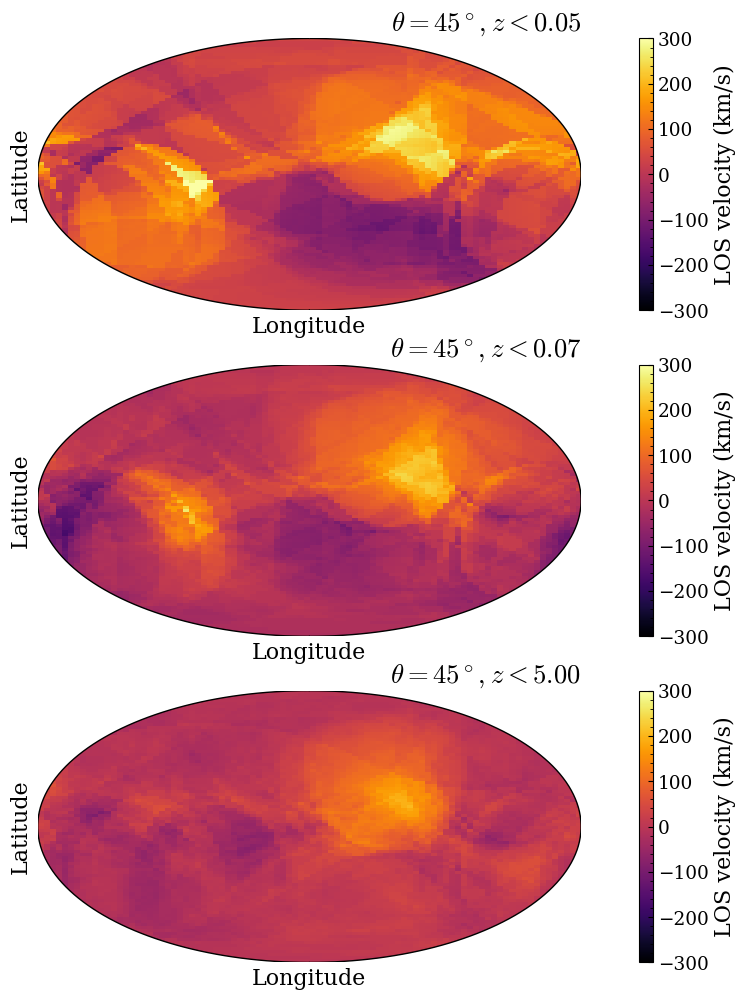

In [4]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
# Use hammer projection
m = Basemap(projection='hammer', lon_0=0)

# -------------------------------||Parameters||---------------------------------
cone_size = 45
lon_step = 4
lat_step = 2
n_clusters = 313
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')
#-------------------------------------------------------------------------------


# Only 313 highest Lcore/Ltot clusters
data = data[:n_clusters]

redshift = data['ObservedRedshift']
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for zmax, ax in zip([0.05, 0.07, 5], axes):
    # Select redshift range
    zmask = (redshift < zmax)
    
    # Calculate los velocity map
    _,_,los_v_map,_ = make_los_v_map(data, zmask, cone_size=cone_size, lon_step=lon_step, lat_step=lat_step)
    
    # Plot the map
    cp._sky_map_(los_v_map, colorbar_label='LOS velocity (km/s)', ax=ax, vmin=-300, vmax=300)

    # Set the title
    ax.set_title(f'$\\theta={cone_size}^\\circ, z<{zmax:.2f}$', loc='right')

    # # Highlight some directions
    # m.scatter(51.49, 13.34, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)
    # m.scatter(50.17, 19.97, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)

plt.show()

## True bulk flow, amplitude and direction.
### Method 1: Summing each cluster and average over them.
Without assuming dipole. The bulk flow is the averaged velocity of each cluster.

In [5]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:n_clusters]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

x = np.array(data['x_lc'])
y = np.array(data['y_lc'])
z = np.array(data['z_lc'])

los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
los_v = np.array(los_v)

v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5


for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    # break

0.0106927399700134 0.1682769161224142
z<0.03, 29 haloes 50.52 km/s (153.31, 11.05)
z<0.05, 88 haloes 23.30 km/s (151.87, 65.88)
z<0.07, 161 haloes 32.19 km/s (52.66, 52.68)
z<0.09, 214 haloes 39.24 km/s (60.89, 43.65)
z<0.11, 248 haloes 38.65 km/s (57.35, 47.49)
z<0.13, 282 haloes 25.49 km/s (46.30, 32.08)
z<0.15, 300 haloes 23.43 km/s (42.82, 23.94)
z<0.17, 313 haloes 20.34 km/s (50.17, 19.97)


### Method 2: Summing all 3-d velocities

In [6]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:313]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

v_vecs = np.column_stack([vx, vy, vz])

for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    # break

0.0106927399700134 0.1682769161224142
z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)
z<0.17, 313 haloes 55.27 km/s (57.67, 39.38)


### Method 2: Maximum dipole flow of opposing direction

In [7]:
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.clusterfit as cf

@njit(fastmath=True)
def find_max_dipole_flow(Glon, Glat, los_v_map, count_map):
    # Find the maximum dipole flow
    max_ubf_dp = 0
    for lon, lat in zip(Glon, Glat):
        if lon < 0: # only do half of the sky
            continue

        # current direction
        los_v = los_v_map[(Glon == lon) & (Glat == lat)]
        count = count_map[(Glon == lon) & (Glat == lat)]

        # get the dipole direction
        dp_lon, dp_lat = cf.opposite_direction(lon, lat)
        dp_mask = (Glon == dp_lon) & (Glat == dp_lat)
        dp_los_v = los_v_map[dp_mask]
        dp_count = count_map[dp_mask]

        # calculate the dipole flow, weighted using number of clusters
        if np.sum(count + dp_count) > 5:
            ubf_dp = (los_v*count - dp_los_v*dp_count)/(count + dp_count)
            ubf_dp = ubf_dp[0]
            if np.abs(ubf_dp) > np.abs(max_ubf_dp): # Find the maximum
                if ubf_dp > 0:
                    max_ubf_dp = ubf_dp
                    max_bf_lon = lon
                    max_bf_lat = lat
                else:
                    max_ubf_dp = -ubf_dp
                    max_bf_lon = dp_lon
                    max_bf_lat = dp_lat

    return max_ubf_dp, max_bf_lon, max_bf_lat

In [8]:
def true_bulk_flow_z(data, method='cluster_average', cone_size=45, n_clusters=313):
    """
    A haphazard function to calculate the bulk flow ubf, vlon, vlat as a function of redshift.
    """
    # Only 313 highest Lcore/Ltot clusters
    data = data[:n_clusters]
    redshift = data['ObservedRedshift']

    # Buffer lists
    zmaxs = []
    ubfs = []
    vlons = []
    vlats = []
    for zmax in np.arange(0.03, 0.16, 0.01):
        zmask = (redshift < zmax)
        Glon, Glat, los_v_map, count_map = make_los_v_map(data, zmask, cone_size=cone_size, lon_step=lon_step, lat_step=lat_step)

        if method=='cone_average':
            # The global bulk flow by averaging all the cones
            bulk_vx = np.average(los_v_map * np.cos(Glat * np.pi / 180) * np.cos(Glon * np.pi / 180), weights=count_map)
            bulk_vy = np.average(los_v_map * np.cos(Glat * np.pi / 180) * np.sin(Glon * np.pi / 180), weights=count_map)
            bulk_vz = np.average(los_v_map * np.sin(Glat * np.pi / 180), weights=count_map)
            ubf, b, l = coord.cartesian_to_spherical(bulk_vx, bulk_vy, bulk_vz) # r, lat, lon
            vlon = l.to('deg').value
            vlat = b.to('deg').value
            print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {ubf:.2f} km/s ({vlon:.2f}, {vlat:.2f})")
            #print(Glon[los_v_map.argmax()], Glat[los_v_map.argmax()], los_v_map.max())
        elif method=='max_dipole':
            # The maximum dipole flow
            ubf, vlon, vlat = find_max_dipole_flow(Glon, Glat, los_v_map, count_map)
            print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes, max dipole flow: {ubf} km/s at ({vlon}, {vlat})")
        elif method=='cluster_average':     
            # Peculiar los velocity
            vx = np.array(data['Vx'])                 # velocities in km/s
            vy = np.array(data['Vy'])
            vz = np.array(data['Vz'])

            v_vecs = np.column_stack([vx, vy, vz])

            # Mask and sum
            bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
            ubf, vlat, vlon = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
            vlon = vlon.to('deg').value
            vlat = vlat.to('deg').value
            print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {ubf:.2f} km/s ({vlon:.2f}, {vlat:.2f})")

        # Save the maximum dipole flow
        ubfs.append(ubf)
        zmaxs.append(zmax)
        vlons.append(vlon)
        vlats.append(vlat)

    ubfs = np.array(ubfs)
    zmaxs = np.array(zmaxs)
    vlons = np.array(vlons)
    vlats = np.array(vlats)
    return zmaxs, ubfs, vlons, vlats 

### The "true" bulk flow only

In [9]:

# import matplotlib.pyplot as plt
# import numpy as np
# from astropy.cosmology import FlatLambdaCDM
# cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
# fig, ax = plt.subplots(figsize=(10, 6))



# # Calculate and plot the bulk flow for the first lightcone
# for i, marker in enumerate(['o', 's']):
#     for cone_size in [30, 45, 60]:
#         data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
#         zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data, cone_size=cone_size,
#                                                      n_clusters=313) # ubf_z returns a list
#         zmaxs = np.array(zmaxs)

#         ax.plot(zmaxs, ubfs, marker=marker, label=f'$\\theta={cone_size}^\\circ$, Lightcone{i}')



# # Set up the plot
# ax.set_xlabel('Redshift')
# ax.set_ylabel('Bulk flow amplitude (km/s)')
# ax.set_xticks(np.linspace(0, 0.2, 11))

# # set a double x label for redshift
# ax2 = ax.twiny()
# ax2.set_xlim(0, 0.2)
# ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
# Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
# xtickslabels = np.round(Dco, -1)
# xtickslabels = np.array(xtickslabels, dtype=int) 
# ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
# ax2.set_xlabel('Distance (Mpc)')

# ax.grid(True)
# ax.set_xlim(0, 0.2)
# ax.set_ylim(0, 750)

# # legend on the bottom ouside of the plot
# ax.legend(loc='upper center', shadow=True, ncol=2)
# plt.show()

## Compare with the modeled bulk flow

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


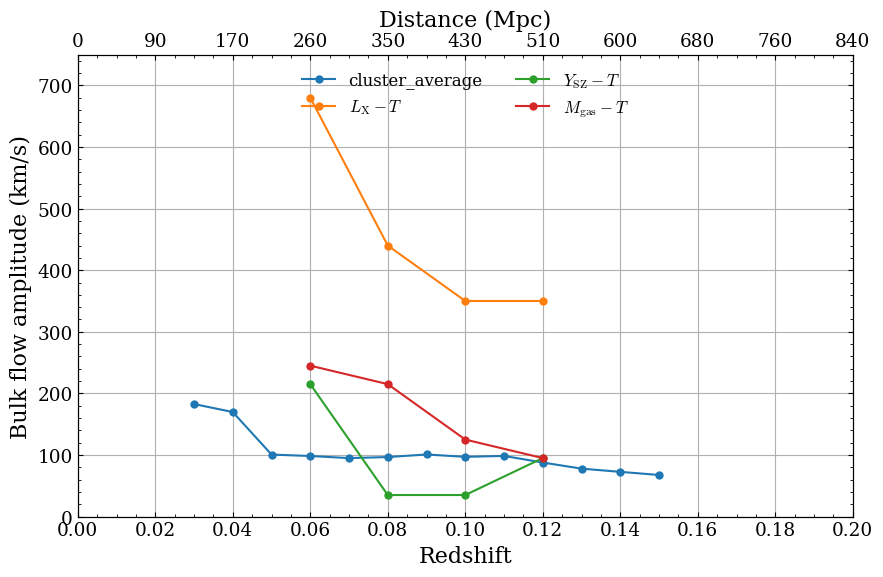

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 0

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data, method) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')



# Plot the modeled bulk flow
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmax = df['zmax'].loc[df['scaling_relation']==relation] # Do LX-T for now
    ubfs = df['ubf'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmax)
    ax.plot(zmaxs, ubfs, marker='o', label=f'{label}')



# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 750)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()

z<0.03, 37 haloes 244.55 km/s (198.25, 19.06)
z<0.04, 53 haloes 197.68 km/s (203.90, 32.23)
z<0.05, 87 haloes 204.47 km/s (210.50, 12.95)
z<0.06, 114 haloes 184.63 km/s (210.24, 6.93)
z<0.07, 151 haloes 173.48 km/s (204.13, 1.84)
z<0.08, 183 haloes 149.16 km/s (201.26, -5.66)
z<0.09, 212 haloes 145.37 km/s (205.11, -8.60)
z<0.10, 237 haloes 133.43 km/s (208.23, -9.32)
z<0.11, 263 haloes 123.39 km/s (209.77, -10.94)
z<0.12, 277 haloes 117.37 km/s (210.22, -6.92)
z<0.13, 291 haloes 116.57 km/s (208.67, -5.27)
z<0.14, 298 haloes 114.53 km/s (211.09, -4.00)
z<0.15, 303 haloes 113.03 km/s (211.89, -1.99)


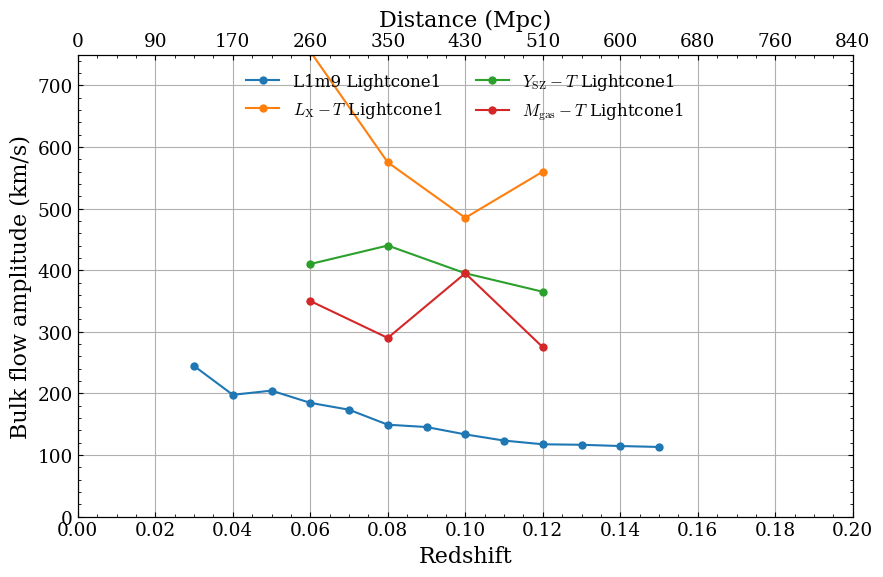

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 1

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data) # ubf_z returns a list
zmaxs = np.array(zmaxs)

ax.plot(zmaxs, ubfs, marker='o', label=f'L1m9 Lightcone{i}')



# Plot the modeled bulk flow
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmax = df['zmax'].loc[df['scaling_relation']==relation] # Do LX-T for now
    ubfs = df['ubf'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmax)
    ax.plot(zmaxs, ubfs, marker='o', label=f'{label} Lightcone{i}')



# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 750)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()

## The direction

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


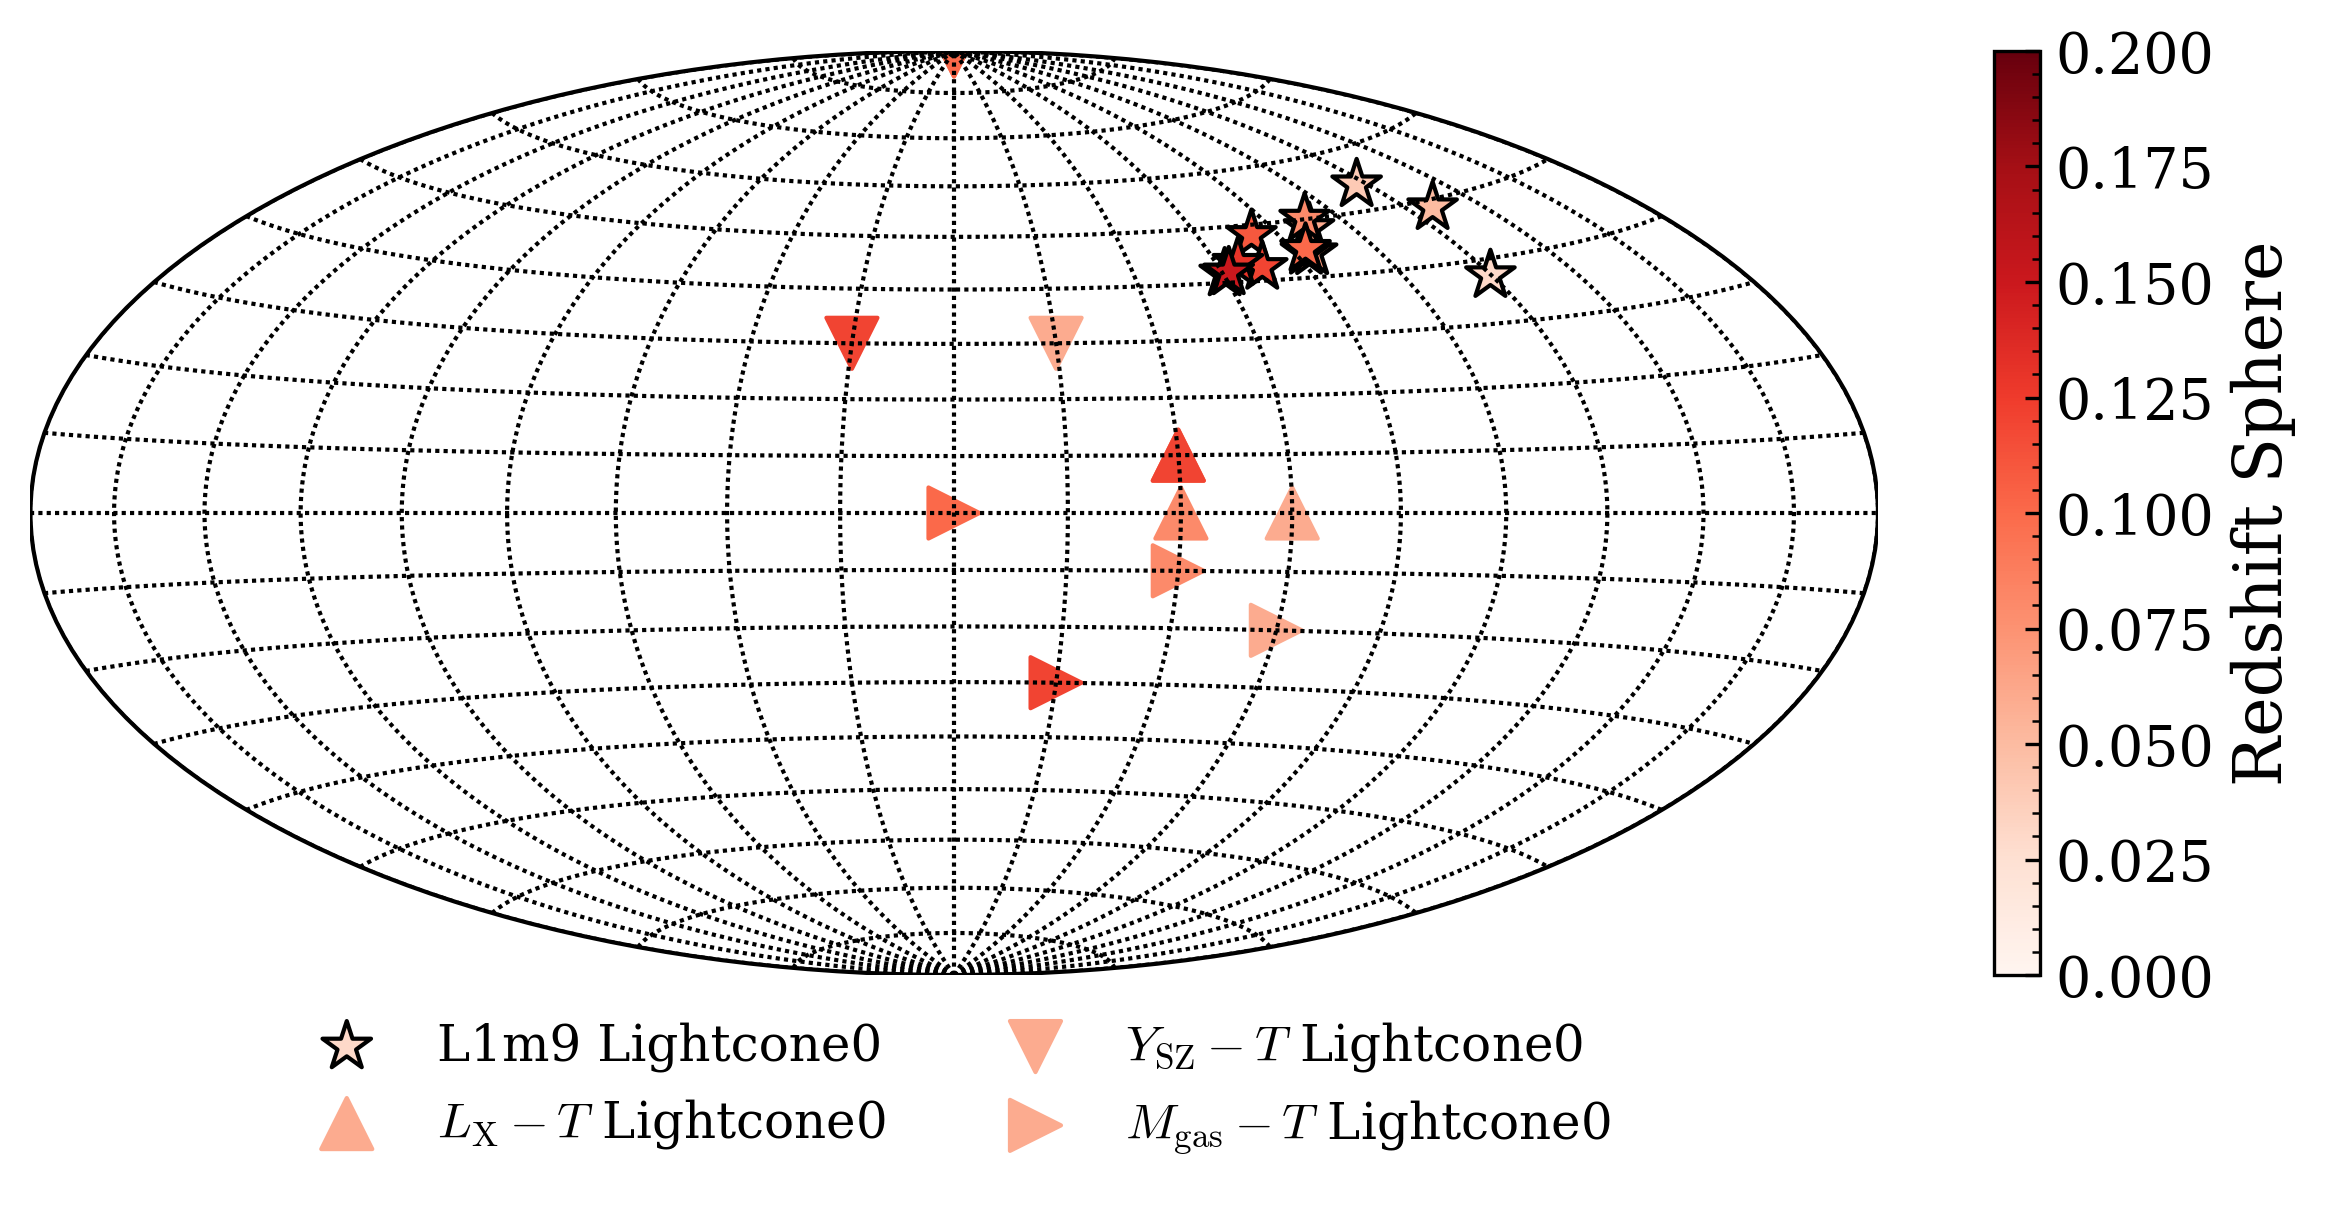

In [18]:
import sys
sys.path.append('../tools/')
import clusterplot as cp

# Lightcone number
i = 0

# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)


# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data) # ubf_z returns a list
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)
# m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)



# Plot the modeled bulk flow
markers = ['^','v','>']
j = 0 # marker index
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmaxs = df['zmax'].loc[df['scaling_relation']==relation]
    vlons = df['lon'].loc[df['scaling_relation']==relation]
    vlats = df['lat'].loc[df['scaling_relation']==relation]
    vlons = np.array(vlons)
    vlats = np.array(vlats)
    vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
    m.scatter(vlons, vlats, marker=markers[j], c=zmaxs, 
                label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
                vmin=0, vmax=0.2, s=150)
    # m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)

    # Add a marker index
    j += 1

    
m.drawparallels(np.arange(-90,90,10.))
m.drawmeridians(np.arange(-180,180,20.))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

z<0.03, 37 haloes 244.55 km/s (198.25, 19.06)
z<0.04, 53 haloes 197.68 km/s (203.90, 32.23)
z<0.05, 87 haloes 204.47 km/s (210.50, 12.95)
z<0.06, 114 haloes 184.63 km/s (210.24, 6.93)
z<0.07, 151 haloes 173.48 km/s (204.13, 1.84)
z<0.08, 183 haloes 149.16 km/s (201.26, -5.66)
z<0.09, 212 haloes 145.37 km/s (205.11, -8.60)
z<0.10, 237 haloes 133.43 km/s (208.23, -9.32)
z<0.11, 263 haloes 123.39 km/s (209.77, -10.94)
z<0.12, 277 haloes 117.37 km/s (210.22, -6.92)
z<0.13, 291 haloes 116.57 km/s (208.67, -5.27)
z<0.14, 298 haloes 114.53 km/s (211.09, -4.00)
z<0.15, 303 haloes 113.03 km/s (211.89, -1.99)


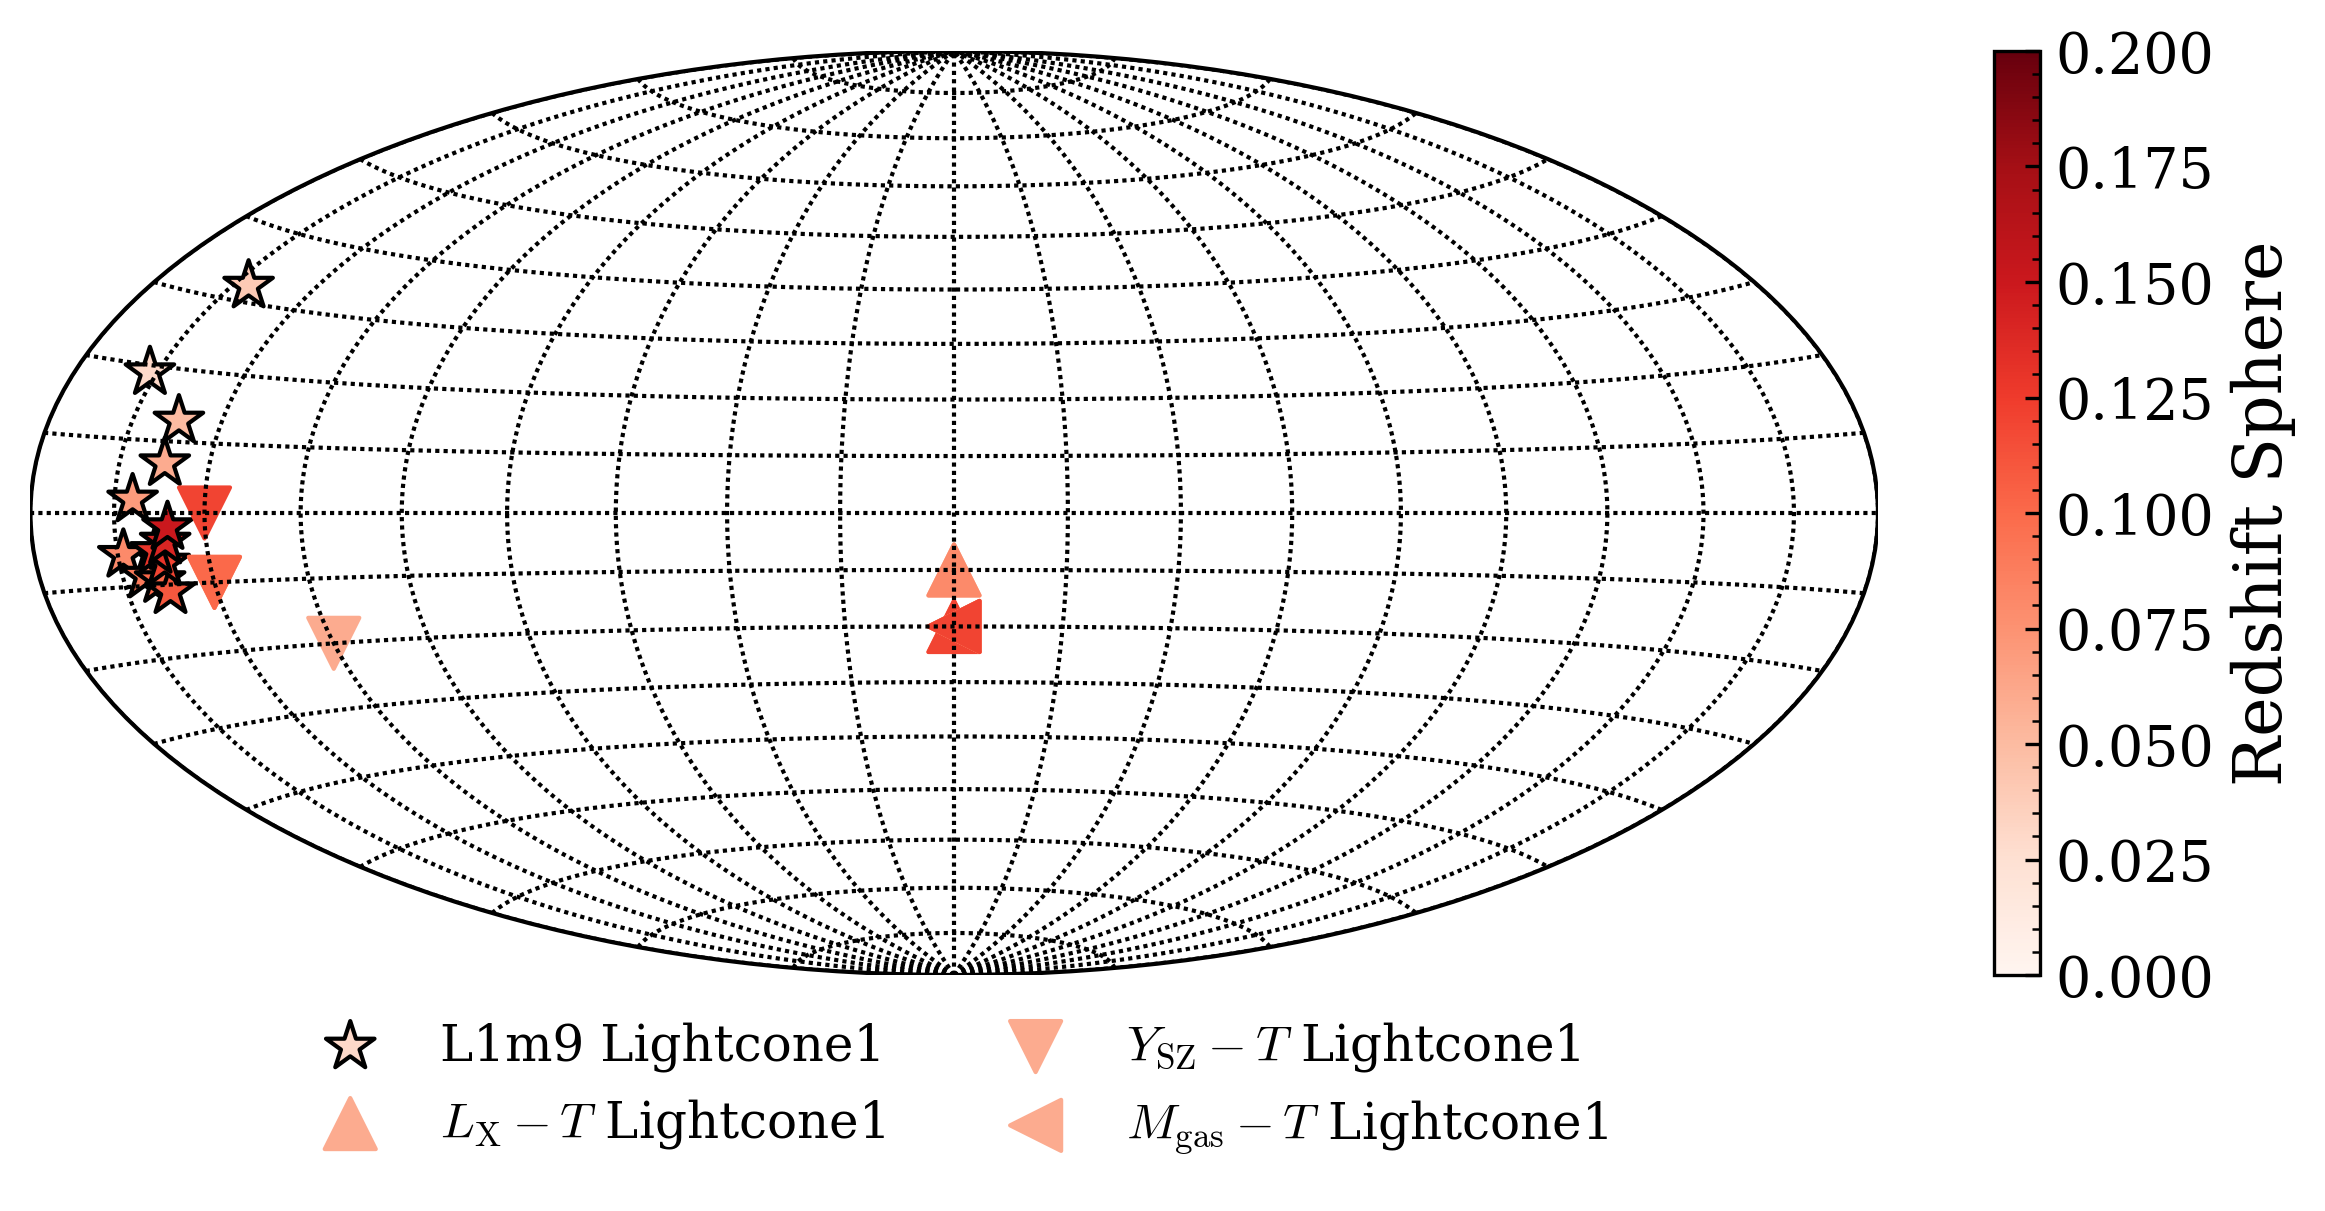

In [17]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
from adjustText import adjust_text

# Lightcone number
i = 1

# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)

# texts = [] # for adjusting texts

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data) # ubf_z returns a list
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)
# m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)



# Plot the modeled bulk flow
markers = ['^','v','<']
j = 0 # marker index
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmaxs = df['zmax'].loc[df['scaling_relation']==relation]
    vlons = df['lon'].loc[df['scaling_relation']==relation]
    vlats = df['lat'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmaxs)
    vlons = np.array(vlons)
    vlats = np.array(vlats)
    vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
    m.scatter(vlons, vlats, marker=markers[j], c=zmaxs, 
                label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
                vmin=0, vmax=0.2, s=150)
    
    # for k, zmax in enumerate(zmaxs):
    #     x, y = m(vlons[k], vlats[k])
    #     # ax.annotate(f'z<{zmax}', (x, y), fontsize=8, color='black')
    #     texts.append(ax.annotate(f'z<{zmax}', (x, y-zmax-1), fontsize=8, color='black'))
    # m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)

    # Add a marker index
    j += 1

# Adjust the texts
# adjust_text(texts, only_move='y-', ax=ax)

m.drawparallels(np.arange(-90,90,10.))
m.drawmeridians(np.arange(-180,180,20.))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

## MCMC results 

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


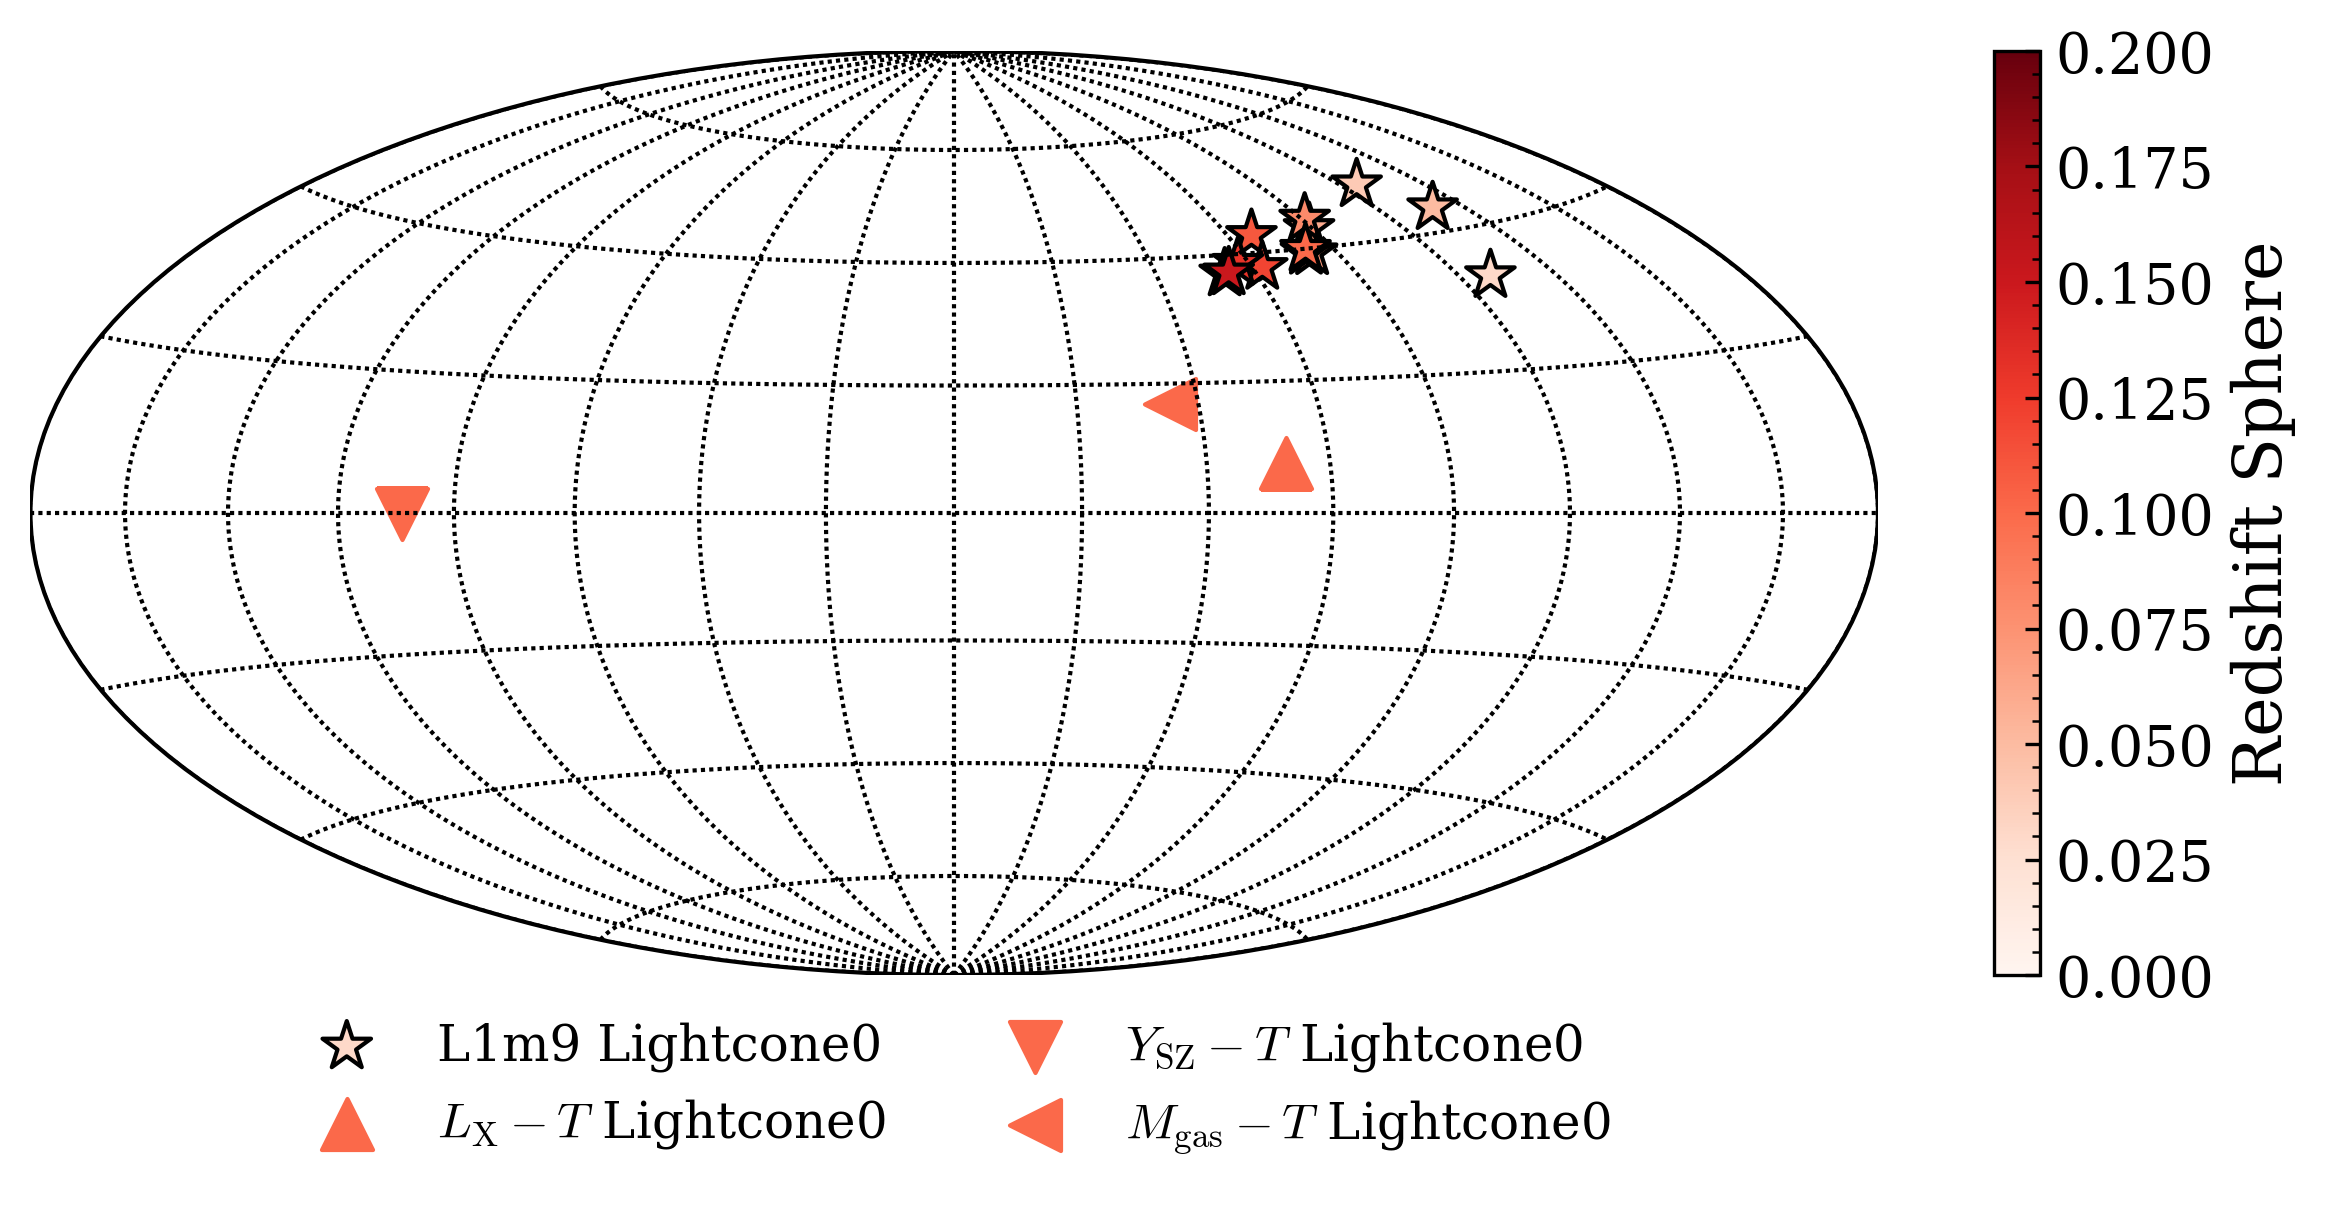

In [14]:
import sys
sys.path.append('../tools/')
import clusterplot as cp

# Lightcone number
i = 0

# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)


# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data) # ubf_z returns a list
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)


# Plot the modeled bulk flow
markers = ['^','v','<']

# LX-T
label = '$L_\\mathrm{{X}}-T$'
zmaxs = [0.1]
vlons = [-120.594]
vlats = [-8.434]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[0], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)

# YSZ-T
label = '$Y_\\mathrm{{SZ}}-T$'
zmaxs = [0.1]
vlons = [80]
vlats = [0.2]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[1], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)

# Mgas-T
label = '$M_\\mathrm{{gas}}-T$'
zmaxs = [0.1]
vlons = [-140.3]
vlats = [-18.9]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[2], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)
    
m.drawparallels(np.arange(-90,90,22.5))
m.drawmeridians(np.arange(-180,180,22.5))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


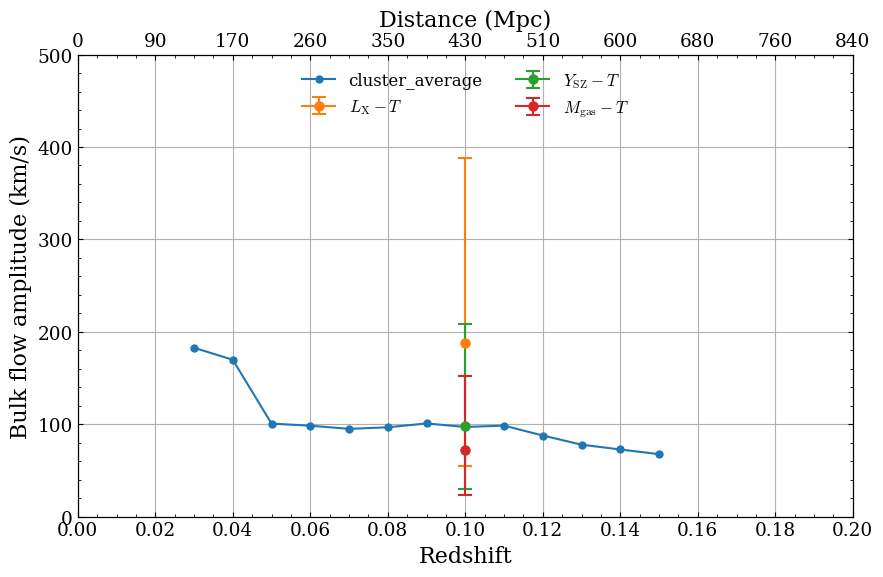

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 0

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = true_bulk_flow_z(data, method) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')



# Plot the modeled bulk flow
#LX-T
label = '$L_\\mathrm{{X}}-T$'
zmaxs = [0.08, 0.10]
ubfs  = [234, 200]
ax.errorbar(zmaxs, ubfs, yerr=[[163,140],
                               [251,228]], 
            marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)


#YSZ-T
label = '$Y_\\mathrm{{SZ}}-T$'
zmaxs = [0.1]
ubfs = [98.5]
ax.errorbar(zmaxs, ubfs, yerr=[[69],[110]], marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)


# Mgas-T
label = '$M_\\mathrm{{gas}}-T$'
zmaxs = [0.1]
ubfs = [71.9]
ax.errorbar(zmaxs, ubfs, yerr=[[49],[80]], marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)


# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 500)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()